In [37]:
from __future__ import absolute_import, division, print_function, unicode_literals

import collections
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import sequence
import simplejson as json
import tensorflow as tf
import pandas as pd
import os
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from sklearn import metrics as skmetrics
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from keras.utils.vis_utils import plot_model
from keras import metrics
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input, Dropout, Embedding, concatenate
from keras.utils.vis_utils import plot_model
from google.cloud import storage
from google.cloud.storage import Blob

client = storage.Client(project="ds5500")

bucket = client.get_bucket("kkbox-data")

#INPUT_PATH = "D:\\Northeastern\\100 pct undersample split\\"
INPUT_PATH = "gs://kkbox-data/data_100_pct_undersample/"

# Load Data

In [39]:
# Load from GCS
temp_path = "/tmp/train_user_logs_padded.npy"
blob = Blob("data_100_pct_undersample/train_user_logs_padded.npy", bucket)
with open(temp_path, "wb") as file_obj:
    blob.download_to_file(file_obj)

In [40]:
X_user_logs = np.load(temp_path)

In [45]:
X_members = pd.read_csv(INPUT_PATH + "X_train_transformed.csv").sort_values("msno").drop(["msno"],axis=1).values
y = pd.read_csv(INPUT_PATH + "y_train.csv", header=None).sort_values(0).drop([0],axis=1).values

# Member Data & SKLearn Logistic Regression

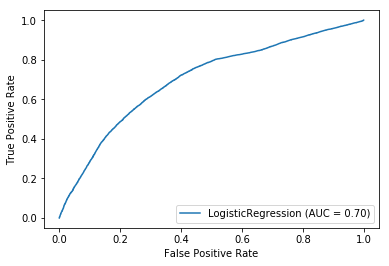

In [34]:
fit = LogisticRegression(random_state=0).fit(X_members, y_flat)
y_pred = fit.predict(X_members)
accuracy_score(y_flat, y_pred)

skmetrics.plot_roc_curve(fit, X_members,y_flat)

# User Logs and Member Data (LSTM)

In [49]:
batch_size = 128
epochs = 10
lstm_units = 24

num_members = X_user_logs.shape[0]
num_dates = X_user_logs.shape[1]
num_user_log_cols = X_user_logs.shape[2]
num_member_cols = X_members.shape[1]

data_in_a = Input(shape = (num_dates,num_user_log_cols))
a = LSTM(lstm_units)(data_in_a)
a = Dense(16, activation='relu')(a)
a_mod = Model(data_in_a, outputs=a)

data_in_b = Input(shape = (num_member_cols,))
b = Dense(16, activation='relu')(data_in_b)
b_mod = Model(data_in_b, outputs=b)

combined = concatenate([a_mod.output, b_mod.output])
c = Dense(1, activation='sigmoid')(combined)

model = Model(inputs=[a_mod.input, b_mod.input], outputs=c)
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = [tf.metrics.AUC()])

model.summary()
model.fit([X_user_logs, X_members], y, batch_size=batch_size, epochs=epochs,verbose=1,use_multiprocessing=True)


Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 762, 7)       0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 24)           3072        input_14[0][0]                   
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 27)           0                                            
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 16)           400         lstm_5[0][0]                     
___________________________________________________________________________________________

# Member data only

In [43]:
batch_size = 128

epochs = 20
features = X_members.shape[1]

data_in = Input(shape = (features,))
x = Dense(1, activation='sigmoid')(data_in)
model = Model(inputs=data_in, outputs=x)
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = [metrics.binary_accuracy])
#model.summary()
model.fit(X_members, y_flat, batch_size=batch_size, epochs=epochs,verbose=1)

#Calculate AUC
y_pred = model.predict(X_members).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_flat, y_pred)
auc(fpr_keras, tpr_keras)

Epoch 1/20
24798/24798 [==============================] - 0s 15us/step - loss: 0.6673 - binary_accuracy: 0.6111
Epoch 2/20
24798/24798 [==============================] - 0s 11us/step - loss: 0.6538 - binary_accuracy: 0.6378
Epoch 3/20
24798/24798 [==============================] - 0s 11us/step - loss: 0.6477 - binary_accuracy: 0.6420
Epoch 4/20
24798/24798 [==============================] - 0s 11us/step - loss: 0.6438 - binary_accuracy: 0.6467
Epoch 5/20
24798/24798 [==============================] - 0s 11us/step - loss: 0.6410 - binary_accuracy: 0.6500
Epoch 6/20
24798/24798 [==============================] - 0s 10us/step - loss: 0.6389 - binary_accuracy: 0.6538
Epoch 7/20
24798/24798 [==============================] - 0s 10us/step - loss: 0.6374 - binary_accuracy: 0.6558
Epoch 8/20
24798/24798 [==============================] - 0s 11us/step - loss: 0.6363 - binary_accuracy: 0.6581
Epoch 9/20
24798/24798 [==============================] - 0s 10us/step - loss: 0.6353 - binary_accuracy:

0.6977788906068529

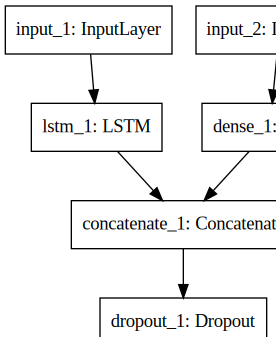

In [10]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))